# ***Machine Learning Project***
# *Data Distillation and Applications of PTMs in it's Process*
# Karan Rezazade
# Fall of 2023 and Winter of 2024

# Introduction
In this project we will be using the following papers:

[1] [Dataset Distillation by Tongzhou Wang, Jun-Yan Zhu, Antonio Torralba, Alexei A. Efros. 27 Nov 2018.](https://https://paperswithcode.com/paper/dataset-distillation)

[2] [Can pre-trained models assist in dataset distillation? by Yao Lu, Xuguang Chen, Yuchen Zhang, Jianyang Gu, Tianle Zhang, Yifan Zhang, Xiaoniu Yang, Qi Xuan, Kai Wang, Yang You. 5 Oct 2023·](https://paperswithcode.com/paper/can-pre-trained-models-assist-in-dataset)


In [1] the following algorithm is proposed for synthesising distilled data for image classification tasks.

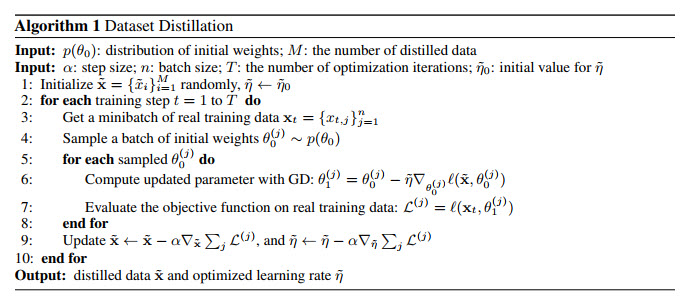


where the loss function is the following loss whlile ƞ is the learning rate.

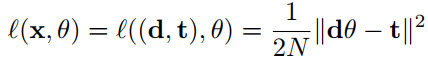

Additionaly [1] mentions that the above algorithm is able to reduce the number of data points to the number of features. Moreover in [2] it is discussed that data distillation is fundementaly equivalent with solving the following optimiztion problem:

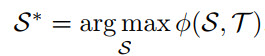

and by adding the following term to the objective function we are able to utilize pre-trained models knowledge to guide the optimization process to a better direction:

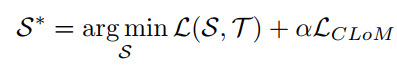

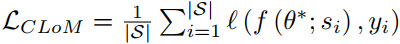

where f is a feature extraction function, l is cross-entropy loss, {S, Y} are synthetic data set and θ is a pre-trained model.

# Goal
Our goal here is to use pre-trained models in Algorithm 1 by adding the cross-entropy term introduced in [2] to it in order to see if the performance of distilled data improves or not. To this end we will be using MNIST-Fashion data set which is an image classification data with 10 classes, VGG16 as pre-trained model and XGboost as evaluation model.

# Experiments:


1. We begin by importing necessary packages.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from scipy.stats import norm
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

2. As stated in Algorithm 1 we need to intialize the process with random weights
but therefore we will be using Xavier method for initiation:

In [ ]:
# Xavier initialization for weights
def xavier_init(M):
    limit = np.sqrt(6 / (M + 1))
    theta0 = np.random.uniform(-limit, limit, size=(M, 1))
    return theta0

3. Since our data is image we will be reshaping data point matrixes to data point vectors for easier computation. Also we will standardize the data.
4. In [1] it is mentioned that an initial learning rate between 0.001 and 0.03 is prefered so we will choose initial learning rate accordingaly.

In [ ]:
# data loading:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
sample_images = np.concatenate((train_images, test_images), axis=0)
sample_labels = np.concatenate((train_labels, test_labels), axis=0)
X = sample_images.reshape(70000, 784)
X = np.array(X)/255
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = tf.constant((X - mean) / std, dtype=tf.float64)
Y = tf.constant(sample_labels.reshape(-1,1), dtype=tf.float64)
theta0 = xavier_init(784)
initial_r = tf.random.uniform(shape=[], minval=0.001 , maxval=0.03, dtype=tf.float64)
initial_z = tf.random.uniform(shape=(28**2, 28**2), dtype=tf.float64)
initial_w = tf.random.uniform(shape=(28**2, 1), dtype=tf.float64)
r = tf.Variable(initial_r, dtype=tf.float64)
z = tf.Variable(initial_z, dtype=tf.float64)
w = tf.Variable(initial_w, dtype=tf.float64)

4422102/4422102 [==============================] - 0s 0us/step


5. In intial trials of Algorithm 1 extreme cases of gradient explosion took place. So in order to accomidate this issue we will calculate 4 times the average of the norm of all the data points (we will consider 4 times the average since the original data points have many 0 values and that might not be the case for synthetic data) to use it as parameter of clipping by norm for gradient with respect to z. Also gradient of all labels and intial weights is calculated as well for the same reason.

In [ ]:
# Calculating some of the necessary norms for clipping:
av_x_norm = tf.Variable(0, dtype=tf.float64)
for row in X:
  tensor_row = tf.constant(row, dtype=tf.float64)
  av_x_norm = tf.Variable(av_x_norm + (4/70000)*tf.norm(tensor_row, ord='euclidean'), dtype=tf.float64)
av_y_norm = tf.norm(Y, ord='euclidean')
tensor_theta0 = tf.constant(theta0, dtype=tf.float64)
av_theta0_norm = tf.norm(tensor_theta0, ord='euclidean')

6. The following is the function of Algorithm 1 without the addition of cross-entropy term.

In [ ]:
# Data Distillation Algorithm:
def DD_algorithm(M_value, T, X, Y, z, w, r, n, initial_theta0, alpha):
  M = tf.constant(M_value, dtype=tf.float64)
  alpha = tf.constant(alpha, dtype=tf.float64)
  theta0 = tf.Variable(initial_theta0, dtype=tf.float64)
  D = []
  batch_size = len(X)//n
  dataset = tf.data.Dataset.from_tensor_slices((X,Y))
  for t in range(T):
    D_t = dataset.shuffle(buffer_size=len(X)).batch(batch_size)
    D.append(D_t)
  for t in range(T):
    print("t: ", t+1)
    print("Learning Rate: ", r)
    for batch, labels in D[t]:
      x = tf.Variable(batch, dtype=tf.float64)
      y = tf.Variable(labels, dtype=tf.float64)
      I = tf.eye(M_value**2, dtype=tf.float64)
      zT = tf.transpose(z)
      theta01 = tf.matmul((I - r/M * tf.matmul(zT, z)), theta0) + (r/M) * tf.matmul(zT, w)
      def Loss(z, w, r):
        t = tf.matmul((I - r/M * tf.matmul(zT, z)), theta0) + (r/M) * tf.matmul(zT, w)
        l = tf.norm(tf.matmul(x, t) - y, ord=2)
        return l
      def Loss_t(t_0):
        l_t = tf.norm(tf.matmul(x, t_0) - y, ord=2)
        return l_t
      with tf.GradientTape(persistent=True) as tape:
        tape.watch(z)
        tape.watch(w)
        tape.watch(r)
        L = Loss(z, w, r)
        tape.watch(theta01)
        L_t = Loss_t(theta01)
      gradient_z = tf.clip_by_norm(tape.gradient(L, z), av_x_norm)
      gradient_w = tf.clip_by_norm(tape.gradient(L, w), av_y_norm)
      gradient_theta = tf.clip_by_norm(tape.gradient(L_t, theta01), av_theta0_norm)
      gradient_r = tf.clip_by_value(tape.gradient(L, r), clip_value_min=0.001, clip_value_max=0.3)
      z = tf.Variable(z - alpha*gradient_z, dtype=tf.float64)
      w = tf.Variable(w - alpha*gradient_w, dtype=tf.float64)
      r = tf.Variable(r - alpha*gradient_r, dtype=tf.float64)
      theta0 = tf.Variable(theta0 - alpha*gradient_theta, dtype=tf.float64)
  S = (z, w, r)
  return S

7. In [1] maximum epochs used were 5 so we will consider this for our experiments but for the sake of performance and limitted hardware we will use 3 epochs. Now we will synthesis the distilled data acording to Algorithm 1.

In [ ]:
# Synthesising distilled data:
for e in range(3):
  print("epoch: ", e+1)
  S = DD_algorithm(28, 30, X, Y, z, w, r, 200, theta0, 0.01)
  z = tf.Variable(S[0], dtype=tf.float64)
  w = tf.Variable(S[1], dtype=tf.float64)
  r = tf.Variable(S[2], dtype=tf.float64)

epoch:  1
t:  1
Learning Rate:  <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.028058908688364033>
t:  2
Learning Rate:  <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.00683109131163589>
t:  3
Learning Rate:  <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.008831091311635808>
t:  4
Learning Rate:  <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.010831091311635727>
t:  5
Learning Rate:  <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.012831091311635645>
t:  6
Learning Rate:  <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.014831091311635564>
t:  7
Learning Rate:  <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.016831091311635484>
t:  8
Learning Rate:  <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.018831091311635403>
t:  9
Learning Rate:  <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.02083109131163532>
t:  10
Learning Rate:  <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.02

8. The new labels that we have built are not sutible for classification since they are continuous values due to gradient approximation. So we will scale them between 0 and 1, multiple the result by 10, and keep only the intiger part, also we will change 10 values to 9. Now we have distinct values between 0 and 9 sutible for classification.

In [ ]:
# Pre-processing distilled data:
DD_sample = np.array(S[0])
DD_label = np.array(S[1])
DD_label = 10*((DD_label - np.min(DD_label)) / (np.max(DD_label) - np.min(DD_label)))
DD_label = np.floor(DD_label).astype(int)
DD_label = np.where(DD_label == 10, 9, DD_label)
DD_train, DD_test, DD_y_train, DD_y_test = train_test_split(DD_sample, DD_label, test_size=0.125, random_state=42)

9. Now we will evaluate their accuracy using XGboost model.

In [ ]:
# Accuracy test on distilled data set:
dtrain = xgb.DMatrix(DD_train, label=DD_y_train)
dtest = xgb.DMatrix(DD_test, label=DD_y_test)
params = {'objective': 'multi:softmax', 'num_class': 10,  'eval_metric': 'merror'}
num_round = 1000
bst = xgb.train(params, dtrain, num_round)
preds = bst.predict(dtest)
accuracy = accuracy_score(DD_y_test, preds)
print("Accuracy: {:.2f} %".format(accuracy * 100))

Accuracy: 17.35 %


10. To continue we need a model trained on the original data with the ability to predict new data some what accurately. To this end and since our original data set is a good set we will use a single batch of 1000 data points to train XGboost on it.

In [ ]:
# Accuracy test on original data set:
train_image = train_images.reshape(60000, 784)
Sample = tf.data.Dataset.from_tensor_slices((train_image,train_labels))
Batches = Sample.shuffle(buffer_size=len(train_image)).batch(1000)
test_image = test_images.reshape(10000, 784)
params = {'objective': 'multi:softmax', 'num_class': 10, 'eval_metric': 'merror'}
dtest = xgb.DMatrix(test_image, label=test_labels)
for batch, labels in Batches:
  dtrain = xgb.DMatrix(batch, label=labels)
  num_round = 1000
  bst = xgb.train(params, dtrain, num_round)
  preds = bst.predict(dtest)
  accuracy = accuracy_score(test_labels, preds)
  print("Accuracy: {:.2f} %".format(accuracy * 100))
  break

Accuracy: 80.65 %


11. Here we rewrite the Algorithm 1 function with addition of the CLoM to the final data points at the end of each iteration.

In [ ]:
# Data Distillation Using Pre-Trained Models Algorithm:
def DD_with_PTMs_algorithm(M_value, T, X, Y, z, w, r, n, initial_theta0, alpha, beta):
  base_model=VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
  M = tf.constant(M_value, dtype=tf.float64)
  alpha = tf.constant(alpha, dtype=tf.float64)
  beta = tf.constant(beta, dtype=tf.float64)
  theta0 = tf.Variable(initial_theta0, dtype=tf.float64)
  D = []
  batch_size = len(X)//n
  dataset = tf.data.Dataset.from_tensor_slices((X,Y))
  for t in range(T):
    D_t = dataset.shuffle(buffer_size=len(X)).batch(batch_size)
    D.append(D_t)
  for t in range(T):
    print("t: ", t+1)
    print("Learning Rate: ", r)
    for batch, labels in D[t]:
      x = tf.Variable(batch, dtype=tf.float64)
      y = tf.Variable(labels, dtype=tf.float64)
      I = tf.eye(M_value**2, dtype=tf.float64)
      zT = tf.transpose(z)
      theta01 = tf.matmul((I - r/M * tf.matmul(zT, z)), theta0) + (r/M) * tf.matmul(zT, w)
      def Loss(z, w, r):
        t = tf.matmul((I - r/M * tf.matmul(zT, z)), theta0) + (r/M) * tf.matmul(zT, w)
        l = tf.norm(tf.matmul(x, t) - y, ord=2)
        return l
      def Loss_t(t_0):
        l_t = tf.norm(tf.matmul(x, t_0) - y, ord=2)
        return l_t
      with tf.GradientTape(persistent=True) as tape:
        tape.watch(z)
        tape.watch(w)
        tape.watch(r)
        L = Loss(z, w, r)
        tape.watch(theta01)
        L_t = Loss_t(theta01)
      gradient_z = tf.clip_by_norm(tape.gradient(L, z), av_x_norm)
      gradient_w = tf.clip_by_norm(tape.gradient(L, w), av_y_norm)
      gradient_theta = tf.clip_by_norm(tape.gradient(L_t, theta01), av_theta0_norm)
      gradient_r = tf.clip_by_value(tape.gradient(L, r), clip_value_min=0.001, clip_value_max=0.3)
      z = tf.Variable(z - alpha*gradient_z, dtype=tf.float64)
      w = tf.Variable(w - alpha*gradient_w, dtype=tf.float64)
      r = tf.Variable(r - alpha*gradient_r, dtype=tf.float64)
      theta0 = tf.Variable(theta0 - alpha*gradient_theta, dtype=tf.float64)
    new_z = np.dstack([z]*3)
    new_z = new_z.reshape(-1, 28, 28, 3)
    new_z = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in new_z])
    new_z = new_z.astype("float64")
    new_w = to_categorical(w, num_classes=10)
    new_z = preprocess_input(new_z)
    new_z = np.array(new_z)
    feature=base_model.predict(new_z)
    feature = np.reshape(feature, (784, 1*1*512))
    dtest = xgb.DMatrix(feature, label=w)
    preds = bst.predict(dtest)
    preds=to_categorical(preds, num_classes=10)
    print
    cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels=new_w, logits=preds)
    cross_entropy_loss = np.array(cross_entropy_loss)
    cross_entropy_loss = cross_entropy_loss/M_value
    L_CLoM  = tf.Variable(cross_entropy_loss, dtype=tf.float64)
    z = tf.Variable(z + beta*L_CLoM, dtype=tf.float64)
  S = (z, w, r)
  return S

12. Now we synthesis a new distilled data set, using CLoM as direction:

In [ ]:
# Synthesising distilled data using PTMs direction:
initial_r = tf.random.uniform(shape=[], minval=0.001 , maxval=0.03, dtype=tf.float64)
initial_z = tf.random.uniform(shape=(28**2, 28**2), dtype=tf.float64)
initial_w = tf.random.uniform(shape=(28**2, 1), dtype=tf.float64)
r = tf.Variable(initial_r, dtype=tf.float64)
z = tf.Variable(initial_z, dtype=tf.float64)
w = tf.Variable(initial_w, dtype=tf.float64)
for e in range(3):
  print("epoch: ", e+1)
  S = DD_with_PTMs_algorithm(28, 30, X, Y, z, w, r, 200, theta0, 0.01, 0.01)
  z = tf.Variable(S[0], dtype=tf.float64)
  w = tf.Variable(S[1], dtype=tf.float64)
  r = tf.Variable(S[2], dtype=tf.float64)

epoch:  1
t:  1
Learning Rate:  <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.026206070779349163>
25/25 [==============================] - 0s 10ms/step
t:  2
Learning Rate:  <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.00569392922065076>
25/25 [==============================] - 0s 10ms/step
t:  3
Learning Rate:  <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.007693929220650679>
25/25 [==============================] - 0s 13ms/step
t:  4
Learning Rate:  <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.009693929220650597>
25/25 [==============================] - 0s 12ms/step
t:  5
Learning Rate:  <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.011693929220650516>
25/25 [==============================] - 0s 10ms/step
t:  6
Learning Rate:  <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.013693929220650434>
25/25 [==============================] - 0s 10ms/step
t:  7
Learning Rate:  <tf.Variable 'Variable:0' shape=() dtype

13. Here we will do the exact same thing as step 8.

In [ ]:
# Pre-processing PTM directed distilled data:
DD_sample = np.array(S[0])
DD_label = np.array(S[1])
DD_label = 10*((DD_label - np.min(DD_label)) / (np.max(DD_label) - np.min(DD_label)))
DD_label = np.floor(DD_label).astype(int)
DD_label = np.where(DD_label == 10, 9, DD_label)
DD_train, DD_test, DD_y_train, DD_y_test = train_test_split(DD_sample, DD_label, test_size=0.125, random_state=42)

14. Finally we evaluate the score:

In [ ]:
# Accuracy test on PTM directed distilled data set:
dtrain = xgb.DMatrix(DD_train, label=DD_y_train)
dtest = xgb.DMatrix(DD_test, label=DD_y_test)
params = {'objective': 'multi:softmax', 'num_class': 10,  'eval_metric': 'merror'}
num_round = 1000
bst = xgb.train(params, dtrain, num_round)
preds = bst.predict(dtest)
accuracy = accuracy_score(DD_y_test, preds)
print("Accuracy: {:.2f} %".format(accuracy * 100))

Accuracy: 11.22 %


# Conclusion
As we can see in this experiment distilled data performance not only didn't improve but also droped by 6 percent. Although it is important to note this cannot be considered as concrete proof since we are running these experiments on google colab enviorment, for further study we need to use local hardware, perform more experiments with more epochs, different α and β And use different pretrained models and different classification models.